In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
from datetime import time
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy.interpolate import interp1d
import sys
import re
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, Latex
from matplotlib.ticker import FuncFormatter, EngFormatter
#from sympy import *

In [2]:
#save_loc = 'C:\\Users\\Erik.Iverson\\Desktop\\PythonPlots\\'
path = os.path.join(r'C:\\', 'Users', 'Erik.Iverson', 'Desktop', 'PythonPlots')
masses = np.array([0,15.7,33.1,33.7,34.8,35.2,81.5,114.8, 211.6,229.4,329.4,425.3,444.8])
forcesN = masses*.001*9.8 # 1000 g in a kg
forcesLBS = masses*.0022 # there are .0022 lbs in a gram

In [3]:
os.chdir(path)
os.getcwd()
contents = os.listdir()

pat = re.compile('^FSR[1-6]_.*csv$')

FSR1data =[elem  for elem in contents if pat.match(elem)]
bladderfill1 = pd.read_csv('BladderFill1.log')

In [ ]:
FSR1data

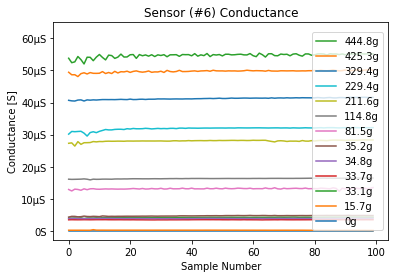

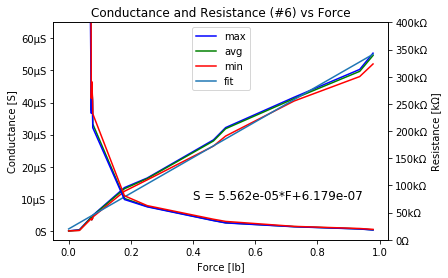

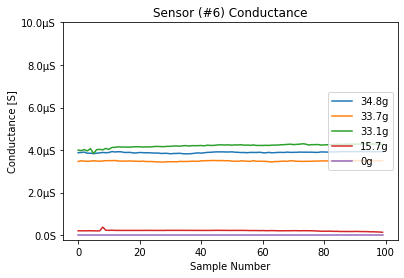

In [43]:
'''
Plot horizontal lines for each column/weight
x axis is index of dataframe
y axis resistances, with labels of weights
'''
filename = FSR1data[5]
results = pd.read_csv(filename, index_col=0)
fig, ax1 = plt.subplots()
for col in results.columns:
    ax1.plot(results.index,1/results[col] , label=col)
major_formatter= EngFormatter(unit='S', places=0, sep='')
ax1.yaxis.set_major_formatter(major_formatter)  
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc='right')
ax1.set_ylim(top=65e-6)
ax1.set_xlabel('Sample Number')
ax1.set_ylabel('Conductance [S]')
ax1.set_title('Sensor (#{}) Conductance'.format(filename[3]))
plt.savefig('sensor{}_conductance_samples'.format(filename[3]))

'''
Now plot avg, min, max conductance and resistance vs weight
Each x-data point has 100 samples to get the min, max, avg of. 

'''
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
#mins = np.array([])
mins = results.apply(np.min, axis=0)
avgs = results.apply(np.mean, axis=0)
slope, intercept, r_value, p_value, std_err = stats.linregress(forcesLBS, 1/avgs)
avgs_bestfit = slope*forcesLBS + intercept


maxs = results.apply(np.max, axis=0)
ax1.set_xlabel('Force [lb]')
ax1.set_ylabel('Conductance [S]')
ax2.set_ylabel('Resistance [k{:c}]'.format(0x3A9))
major_formatter= EngFormatter(unit='S', places=0, sep='')
ax1.yaxis.set_major_formatter(major_formatter)
major_formatter= EngFormatter(unit='{:c}'.format(0x3A9), places=0, sep='')
ax2.yaxis.set_major_formatter(major_formatter)
ax1.plot(forcesLBS, 1/mins, label='max', color='blue')
ax1.plot(forcesLBS, 1/avgs, label='avg', color='green')
ax1.plot(forcesLBS, 1/maxs, label='min', color='red')
ax1.plot(forcesLBS, avgs_bestfit, label='fit')
ax2.set_ylim(top=.4e6)
ax1.set_ylim(top=65e-6)
ax2.plot(forcesLBS, avgs, color='green')
ax2.plot(forcesLBS, mins, color='blue')
ax2.plot(forcesLBS, maxs, color='red')
ax1.legend(loc='upper center')
ax1.set_title('Conductance and Resistance (#{}) vs Force'.format(filename[3]))

#sub1 = tb("$R = \\frac{}{}$")

ax1.text(.4, 10e-6, f'S = {slope:.3e}*F+{intercept:.3e}', fontsize=12)

plt.savefig('sensor{}_conductance_force'.format(filename[3]))

fig, ax1 = plt.subplots()
for col in reversed(results.columns[:5]):
    ax1.plot(results.index, 1/results[col],label=col )
major_formatter= EngFormatter(unit='S', places=1, sep='')
ax1.yaxis.set_major_formatter(major_formatter)  
ax1.legend(loc='right')
ax1.set_ylim(top=10e-6)
ax1.set_xlabel('Sample Number')
ax1.set_ylabel('Conductance [S]')
ax1.set_title('Sensor (#{}) Conductance'.format(filename[3]))
plt.savefig('sensor{}_maxconductance_samples'.format(filename[3]))

In [5]:
'''
Plot the AVERAGE of every sensor's AVERAGE at each force
Zoom in and add trendline and best fit equation
'''
#avgs = np.array()
avgs = pd.DataFrame(columns= forcesLBS, index=[0,1,2,3,4,5]) #each row is a sensor's average at each force, columns are different forces

for filename in FSR1data:
    results = pd.read_csv(filename, index_col=0)
    avgs.iloc[int(filename[3])-1,:] = results.apply(np.mean, axis=0).values

    
total_avgs = avgs.apply(np.mean, axis=0)   


    

Text(0.4, 1e-05, 'S = 5.93e-05*force')

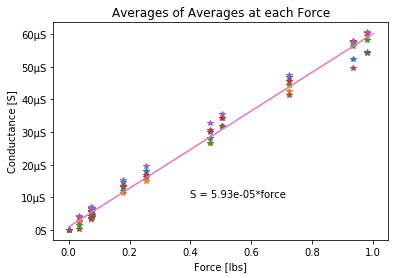

In [6]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Force [lbs]')
ax1.set_ylabel('Conductance [S]')
#ax1.set_label('Conductance [S]')
ax1.set_title('Averages of Averages at each Force')
major_formatter= EngFormatter(unit='S', places=0, sep='')
ax1.yaxis.set_major_formatter(major_formatter)
'''
plot *'s for each sensors average at that weight
plot a best fit line to the average of each *
'''
for idx in avgs.index:
    ax1.plot(avgs.columns, 1/avgs.iloc[idx,:], marker='*', linestyle='none')
#ax1.plot(avgs.columns, 1/total_avgs)
slope, intercept, r_value, p_value, std_err = stats.linregress(avgs.columns, 1/total_avgs)
test_forces = np.linspace(0,1,10)
sensor_value = test_forces*slope+intercept
ax1.plot(test_forces, sensor_value)

ax1.text(.4, 10e-6, 'S = {:.2e}*force'.format(slope))
#ax1.text(.4, 10e-6, '{:c} = {:.2e}*force'.format(0x3A9,slope))

In [7]:
pat = re.compile('^snsr[1-6].*log$')
FSR_setup_data =[elem  for elem in contents if pat.match(elem)]
FSR_setup_data

['snsr1check.log',
 'snsr2check.log',
 'snsr3check.log',
 'snsr4check.log',
 'snsr5check.log',
 'snsr6check.log']

In [8]:
filename = FSR_setup_data[5]
results = pd.read_csv(filename)#, index_col=0)
results
print(type(results.iloc[1,0]))
print(results.iloc[1,0])
print(results.columns)

<class 'str'>
16:18:48
Index(['Time', 'DAQC0.sensor6:'], dtype='object')


In [ ]:
%matplotlib inline

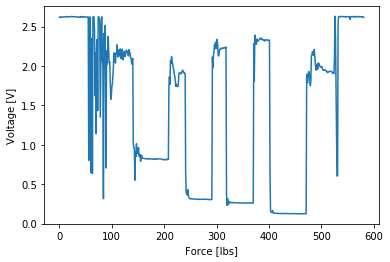

In [9]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Force [lbs]')
ax1.set_ylabel('Voltage [V]')
ax1.plot(results.index,results.iloc[:,1])

In [10]:
jigtop = 15.7
grams = np.array([0, jigtop,jigtop+ 19.1, jigtop+ 65.8, jigtop+ 99.1,jigtop+  195.9])
lbs = grams*.0022
test_lbs = np.linspace(0, .5, 100)
snsr1_vdiv = np.array([2.55, 1.38,.62,.32,.215,.13])
snsr2_vdiv = np.array([2.623,1.427,.868,.340,.218,.128])
snsr3_vdiv = np.array([2.631,1.947,.746,.279,.212,.127])
snsr4_vdiv = np.array([2.633,1.718,.771,.305,.230,.128])
snsr5_vdiv = np.array([2.631,1.039,.546,.230,.197,.110])
snsr6_vdiv = np.array([2.625,2.154,.813,.307,.263,.125])



In [11]:
#calDF = pd.DataFrame()
dataDF = pd.DataFrame(data={1:snsr1_vdiv, 2:snsr2_vdiv, 3:snsr3_vdiv, 4:snsr4_vdiv, 5:snsr5_vdiv, 6:snsr6_vdiv}, index=lbs)
print(dataDF)
#get the linear regression of 1/Vdiv for each column of sensor data
#regrDF (regression data frame) is a series of slope,intercept fittings
regrS = dataDF.apply(lambda x: stats.linregress(x.index, 1/x), axis=0)
#regrDF = pd.DataFrame(index=test_lbs, data=[x for x in regrS.values])
print(regrS)
print(type(regrS))
conductanceFit = regrS.apply(lambda x: x.slope*test_lbs + x.intercept)

             1      2      3      4      5      6
0.00000  2.550  2.623  2.631  2.633  2.631  2.625
0.03454  1.380  1.427  1.947  1.718  1.039  2.154
0.07656  0.620  0.868  0.746  0.771  0.546  0.813
0.17930  0.320  0.340  0.279  0.305  0.230  0.307
0.25256  0.215  0.218  0.212  0.230  0.197  0.263
0.46552  0.130  0.128  0.127  0.128  0.110  0.125
1    (16.017373209079526, 0.3408279531373024, 0.998...
2    (16.51990596234932, 0.15248751688818274, 0.997...
3    (16.81569172642209, 0.24185239229176902, 0.995...
4    (16.429339133699436, 0.1882064384851354, 0.998...
5    (18.786384166375274, 0.4572056605400854, 0.996...
6    (16.636499668172874, 0.05954173469245916, 0.99...
dtype: object
<class 'pandas.core.series.Series'>


In [12]:
print(conductanceFit)
conductanceDF = pd.DataFrame(index=test_lbs, columns = np.linspace(1,6, 6, dtype=int))
for i in range(1,7):
    conductanceDF.loc[:,i]= conductanceFit[i]
conductanceDF

1    [0.3408279531373024, 0.42172377742558287, 0.50...
2    [0.15248751688818274, 0.2359213853848965, 0.31...
3    [0.24185239229176902, 0.32678012828379976, 0.4...
4    [0.1882064384851354, 0.2711828987563447, 0.354...
5    [0.4572056605400854, 0.5520863886530918, 0.646...
6    [0.05954173469245916, 0.14356446028929187, 0.2...
dtype: object


,1,2,3,4,5,6
0.000000,0.340828,0.152488,0.241852,0.188206,0.457206,0.0595417
0.005051,0.421724,0.235921,0.32678,0.271183,0.552086,0.143564
0.010101,0.50262,0.319355,0.411708,0.354159,0.646967,0.227587
0.015152,0.583515,0.402789,0.496636,0.437136,0.741848,0.31161
0.020202,0.664411,0.486223,0.581563,0.520112,0.836729,0.395633
...,...,...,...,...,...,...
0.479798,8.02593,8.07871,8.30999,8.07097,9.47087,8.0417
0.484848,8.10683,8.16214,8.39492,8.15395,9.56576,8.12572
0.489899,8.18772,8.24557,8.47984,8.23692,9.66064,8.20975
0.494949,8.26862,8.32901,8.56477,8.3199,9.75552,8.29377


In [13]:
def tb(mystr):
    a = mystr.replace('{', '{{{')
    return a.replace('}','}}}')

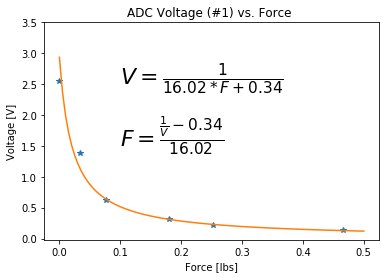

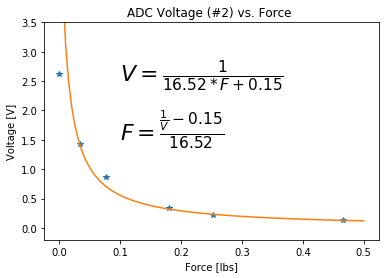

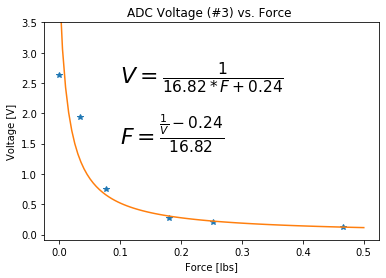

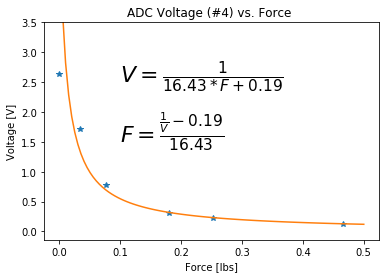

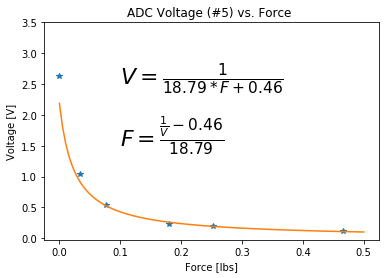

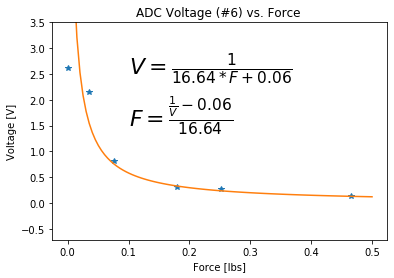

In [14]:
for i in range(1, 7):

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Force [lbs]')
    ax1.set_ylabel('Voltage [V]')
    ax1.set_title('ADC Voltage (#{}) vs. Force '.format(i))
    ax1.plot(lbs, dataDF[i], linestyle='none', marker='*')
    ax1.plot(test_lbs, 1/conductanceFit[i])
    ax1.set_ylim(top=3.5)

    sub1 = tb("$V = \\frac{}{}$")
    sub2 = tb("$F = \\frac{}{}$")
    sub3 = tb("\\frac{}{}")
    ax1.text(.1,2.5, sub1.format(1,'{:.2f}*F + {:.2f}'.format(regrS[i].slope, regrS[i].intercept)), fontsize=22)
    ax1.text(.1,1.5, sub2.format(sub3.format(1, 'V')+'-{:.2f}'.format(regrS[i].intercept), '{:.2f}'.format(regrS[i].slope)), fontsize=22)
    plt.savefig('Sensor{}_ADC_Cal'.format(i))

In [ ]:
regrS

In [ ]:
bladderfill1.head()

In [75]:
bladderfill1.head()
bladderfill1['sensor1force'] = ((1/bladderfill1['DAQC0.sensor1'])-regrS[1].intercept)/regrS[1].slope
bladderfill1['sensor2force'] = ((1/bladderfill1['DAQC0.sensor2'])-regrS[2].intercept)/regrS[2].slope
bladderfill1['sensor3force'] = ((1/bladderfill1['DAQC0.sensor3'])-regrS[3].intercept)/regrS[3].slope
bladderfill1['sensor4force'] = ((1/bladderfill1['DAQC0.sensor4'])-regrS[4].intercept)/regrS[4].slope
bladderfill1.loc[bladderfill1['DAQC0.sensor5'] < 0, 'DAQC0.sensor5'] = 0
bladderfill1['sensor5force'] = ((1/bladderfill1['DAQC0.sensor5'])-regrS[5].intercept)/regrS[5].slope

bladderfill1['sensor6force'] = ((1/bladderfill1['DAQC0.sensor6'])-regrS[6].intercept)/regrS[6].slope



mask = bladderfill1['sensor1force'] > 1# | (bladderfill1['sensor1force'] < 0)
bladderfill1.loc[mask, 'sensor1force'] = 1
mask = bladderfill1['sensor2force'] > 1
bladderfill1.loc[mask, 'sensor2force'] = 1
mask = bladderfill1['sensor3force'] > 1
bladderfill1.loc[mask, 'sensor3force'] = 1
mask = bladderfill1['sensor4force'] > 1
bladderfill1.loc[mask, 'sensor4force'] = 1

mask = bladderfill1['sensor5force'] > 1 
bladderfill1.loc[mask, 'sensor5force'] = 1
mask = bladderfill1['sensor5force'] < 0
bladderfill1.loc[600:1000, 'sensor5force'] = 1

mask = bladderfill1['sensor6force'] > 1
bladderfill1.loc[mask, 'sensor6force'] = 1


#bladderfill1.sensor1force[bladderfill1.sensor1force > 1] = 1   THIS IS A BAD WAY TO DO IT


In [ ]:
bladderfill1.head()

In [ ]:
bladderfill1.loc[sensor1force] = 1


In [ ]:
bladderfill1.head()
bladderfill1.sensor1force

In [ ]:
%matplotlib qt

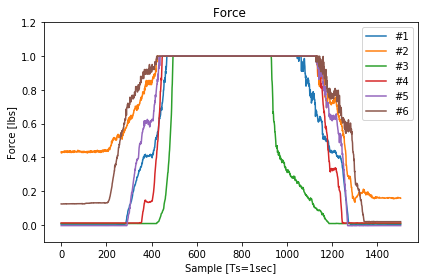

In [76]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('Force [lbs]')
ax1.set_xlabel('Sample [Ts=1sec]')
ax1.set_title('Force ')
ax1.plot(bladderfill1.index,bladderfill1['sensor1force'], label='#1')# , linestyle='none', marker='*')
ax1.plot(bladderfill1.index,bladderfill1['sensor2force'], label='#2')
ax1.plot(bladderfill1.index,bladderfill1['sensor3force'], label='#3')
ax1.plot(bladderfill1.index,bladderfill1['sensor4force'], label='#4')
ax1.plot(bladderfill1.index,bladderfill1['sensor5force'], label='#5')
ax1.plot(bladderfill1.index,bladderfill1['sensor6force'], label='#6')
ax1.legend()
ax1.set_ylim(bottom = -.1, top=1.2)
fig.tight_layout()

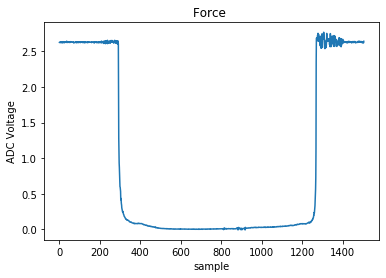

In [17]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('ADC Voltage')
ax1.set_xlabel('sample')
ax1.set_title('Force ')
ax1.plot(bladderfill1.index,bladderfill1['DAQC0.sensor5'])# , linestyle='none', marker='*')
#ax1.plot(test_lbs, 1/conductanceFit[i])
#ax1.set_xlim(left=200, right=1200)

In [ ]:
min(bladderfill1['DAQC0.sensor1'])

In [28]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

In [26]:
from sympy import *
Rt = symbols('R_t', real=True, positive=True)
Rs = symbols('R_s', real=True, positive=True)
Rb = symbols('R_b', real=True, positive=True)
Vs = symbols('V_s',real=True, positive=True )
Vdiv = symbols('V_{div}',real=True, positive=True)
Rpar = Rs*Rb/(Rs+Rb)
rhs = Rpar/(Rpar+Rt)
rhs

solveset(Vdiv - rhs, Rs)
#pprint(f'1/Vdiv = {1/Vdiv}')
#simplify(1/Vdiv)

#eq = Vdiv - simplify(1/Vdiv)
#eq

R_b*R_s/((R_b + R_s)*(R_b*R_s/(R_b + R_s) + R_t))

Complement(FiniteSet(-R_b*R_t*V_{div}/(R_b*V_{div} - R_b + R_t*V_{div})), FiniteSet(-R_b*R_t/(R_b + R_t)))

In [ ]:
#find Rs with Vdiv, Rt=2e6, Rb=1e6 known.
#alternatively, go from V -> F -> Resistance, then Vout_pcba = 1*(1+Rf/Rsns)

In [77]:
#find Rs with Vdiv, Rt=2e6, Rb=1e6 known. 
#bladderfill1['fsr1_s'] = ((1/bladderfill1['DAQC0.sensor1'] - .34) / 16.02) * 5.604e-6 + 2.522e-6
#bladderfill1['fsr2_s'] = ((1/bladderfill1['DAQC0.sensor2'] - .15) / 16.52) * 6.069e-5 - 1.547e-7
#bladderfill1['fsr3_s'] = ((1/bladderfill1['DAQC0.sensor3'] - .24) / 16.82) * 5.945e-5 + 7.35e-7
#bladderfill1['fsr4_s'] = ((1/bladderfill1['DAQC0.sensor4'] - .19) / 16.43) * 6.074e-5 + 1.697e-6
#bladderfill1['fsr5_s'] = ((1/bladderfill1['DAQC0.sensor5'] - .46) / 18.79) * 6.076e-5 + 2.58e-6  
#bladderfill1['fsr6_s'] = ((1/bladderfill1['DAQC0.sensor6'] - .06) / 16.64) * 5.562e-5 + 6.179e-7

bladderfill1['fsr1_s'] = bladderfill1['sensor1force'] * 5.604e-6 + 2.522e-6
bladderfill1['fsr2_s'] = bladderfill1['sensor2force']* 6.069e-5 - 1.547e-7
bladderfill1['fsr3_s'] = bladderfill1['sensor3force'] * 5.945e-5 + 7.35e-7
bladderfill1['fsr4_s'] = bladderfill1['sensor4force']* 6.074e-5 + 1.697e-6
bladderfill1['fsr5_s'] = bladderfill1['sensor5force']* 6.076e-5 + 2.58e-6  
bladderfill1['fsr6_s'] = bladderfill1['sensor6force'] * 5.562e-5 + 6.179e-7

bladderfill1.loc[bladderfill1.fsr1_s > 60e-6 , 'fsr1_s'] = 80e-6  
bladderfill1.loc[bladderfill1.fsr2_s > 60e-6 , 'fsr2_s'] = 80e-6  
bladderfill1.loc[bladderfill1.fsr3_s > 60e-6 , 'fsr3_s'] = 80e-6  
bladderfill1.loc[bladderfill1.fsr4_s > 60e-6 , 'fsr4_s'] = 80e-6  
bladderfill1.loc[bladderfill1.fsr5_s > 60e-6 , 'fsr5_s'] = 80e-6  
#bladderfill1.loc[bladderfill1.fsr5_s < 0 , 'fsr5_s'] = 0
bladderfill1.loc[bladderfill1.fsr6_s > 60e-6 , 'fsr6_s'] = 80e-6  


In [78]:
bladderfill1['fsr1_vout'] = .6*(1+90e3*bladderfill1['fsr1_s'])
bladderfill1['fsr2_vout'] = .6*(1+90e3*bladderfill1['fsr2_s'])
bladderfill1['fsr3_vout'] = .6*(1+90e3*bladderfill1['fsr3_s'])
bladderfill1['fsr4_vout'] = .6*(1+90e3*bladderfill1['fsr4_s'])
bladderfill1['fsr5_vout'] = .6*(1+90e3*bladderfill1['fsr5_s'])
bladderfill1['fsr6_vout'] = .6*(1+90e3*bladderfill1['fsr6_s'])

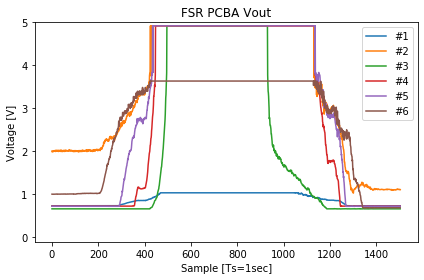

In [79]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('Voltage [V]')
ax1.set_xlabel('Sample [Ts=1sec]')
ax1.set_title('FSR PCBA Vout')
ax1.plot(bladderfill1.index,bladderfill1['fsr1_vout'], label='#1')# , linestyle='none', marker='*')
ax1.plot(bladderfill1.index,bladderfill1['fsr2_vout'], label='#2')
ax1.plot(bladderfill1.index,bladderfill1['fsr3_vout'], label='#3')
ax1.plot(bladderfill1.index,bladderfill1['fsr4_vout'], label='#4')
ax1.plot(bladderfill1.index,bladderfill1['fsr5_vout'], label='#5')
ax1.plot(bladderfill1.index,bladderfill1['fsr6_vout'], label='#6')
ax1.legend()
ax1.set_ylim(bottom = -.1, top=5)
fig.tight_layout()

In [ ]:
"\\frac{{{}}}{{{}}}".format(1,3)

In [23]:
a = symbols('alpha', real=True)
b = symbols('beta', real=True)
x = symbols('x', real=True)
v = symbols('v', real=True)
ex = v - 1/(a*x+b)
y = solveset(ex, x)
y

Complement(FiniteSet(-(beta - 1/v)/alpha), FiniteSet(-beta/alpha))

In [ ]:
df = pd.DataFrame(np.random.randn(8, 3), columns=["A", "B", "C"])
df

In [ ]:
df.A[df.A > 0] = 99 #BAD METHOD!!
df

In [ ]:
def f(v):
    '''
    force as a function of resistive divider voltage
    if v > 1/.3, the force would be negative, can't have that
    1/v - .3 > 0
    1/v > .3
    v < 1/.3
    
    '''
    return ((1/v)-.3)/16

'''
What is the delta in force per ADC count across the full scale range? 
At small changes in voltage (higher range of force), what force value 
is it that the ADC can't resolve?
The ADC advertises 336uV / count
Then, if the v axis is binned into ~3V/336uV = 8928 counts,
What is the delta in force between each of those bins? 
delta_Fn = f(v_n+1) - f(v_n)
'''
vf = 3
adc_counts = 900
adc_counts = np.linspace(336e-6, vf, adc_counts)
forces = f(adc_counts)
dforces =  forces[1:]-  forces[0:-1] 



In [ ]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('ADC Voltage')
ax1.set_ylabel('Delta in Force')
ax1.set_ylim(top=.001, bottom=-.002)
ax1.set_title('hello ')
ax1.plot( adc_counts[0:-1],dforces)# , linestyle='none', marker='*')

In [ ]:
a = np.linspace(0, 10, 11)
print(a)
b = a[1:] - a[0:-1] 
print(b)

In [ ]:
'''
Collected Voltage - 
back out resistance 
get FSR board's anticipated Vout = 1*(1+Rf/Rsns)
'''